# Task 4 :- Sentiment analysis and visualization of social media opinions (Borderlands example)

Analyze and visualize sentiment patterns in social media data to understand public opinion and attitudes towards specific topics or brands.

In [1]:
# Imports and setup

import re
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sys, subprocess
try:
    from wordcloud import WordCloud
except Exception:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import joblib

# Optional downloads - uncomment if running first time

nltk.download('stopwords')
nltk.download('wordnet')

sns.set(style='whitegrid')
STOP = set(stopwords.words('english'))
LEM = WordNetLemmatizer()
RND = 42

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\patil\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\patil\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [2]:
# Preprocessing function and data load

def preprocess_text(s):
    if pd.isna(s):
        return ""
    s = str(s).lower()
    s = re.sub(r'http\S+|www\S+', ' ', s)      # remove urls
    s = re.sub(r'@\w+', ' ', s)                # remove mentions
    s = re.sub(r'#', ' ', s)                   # drop hash sign
    s = re.sub(r'[^a-z\s]', ' ', s)            # keep letters and spaces
    tokens = [LEM.lemmatize(t) for t in s.split() if t not in STOP and len(t) > 1]
    return ' '.join(tokens)

train_path = 'twitter_training.csv'
valid_path = 'twitter_validation.csv'

train = pd.read_csv(train_path, header=None, engine='python',
                    names=['tweet_id','topic','sentiment','text'], encoding='utf-8')
valid = pd.read_csv(valid_path, header=None, engine='python',
                    names=['tweet_id','topic','sentiment','text'], encoding='utf-8')

# Basic cleaning and preprocessing

train['text'] = train['text'].astype(str).str.strip()
valid['text'] = valid['text'].astype(str).str.strip()
train = train.dropna(subset=['text']).reset_index(drop=True)
valid = valid.dropna(subset=['text']).reset_index(drop=True)

train['clean'] = train['text'].map(preprocess_text)
valid['clean'] = valid['text'].map(preprocess_text)

print('Train size:', train.shape)
print('Valid size:', valid.shape)

Train size: (74682, 5)
Valid size: (1000, 5)


C:\Users\patil\AppData\Local\Temp\ipykernel_9484\1020131577.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=train, x='sentiment', order=order, palette='pastel')


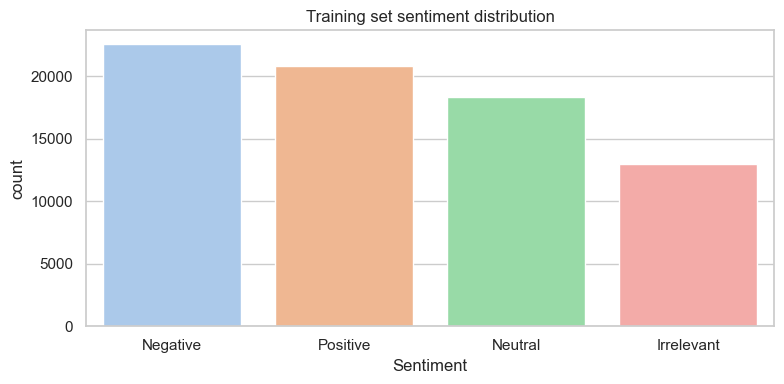

C:\Users\patil\AppData\Local\Temp\ipykernel_9484\1020131577.py:13: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_topics.values, y=top_topics.index, palette='muted')


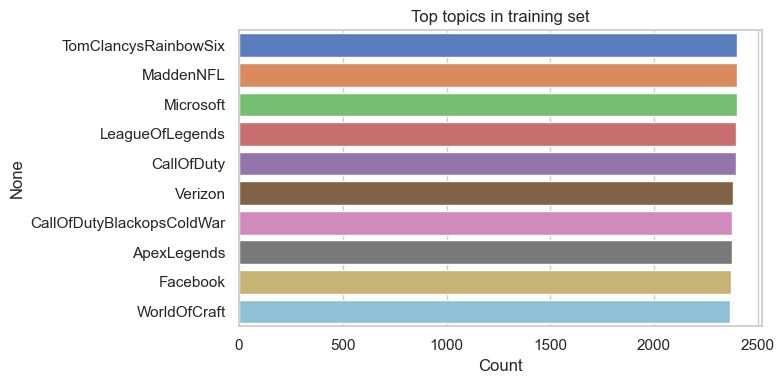

In [3]:
# EDA: sentiment distribution and top topics

plt.figure(figsize=(8,4))
order = train['sentiment'].value_counts().index
sns.countplot(data=train, x='sentiment', order=order, palette='pastel')
plt.title('Training set sentiment distribution')
plt.xlabel('Sentiment')
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
top_topics = train['topic'].value_counts().nlargest(10)
sns.barplot(x=top_topics.values, y=top_topics.index, palette='muted')
plt.title('Top topics in training set')
plt.xlabel('Count')
plt.tight_layout()
plt.show()

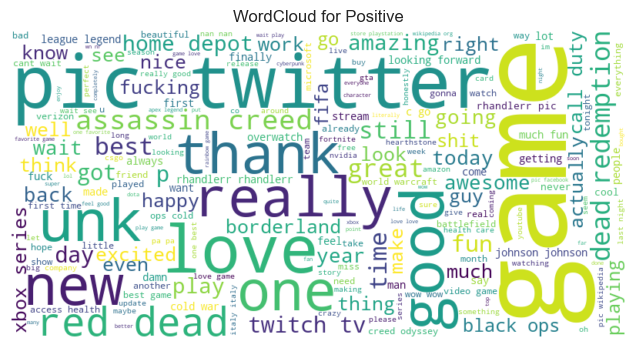

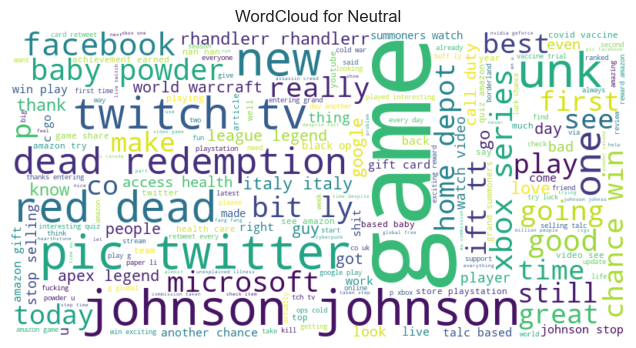

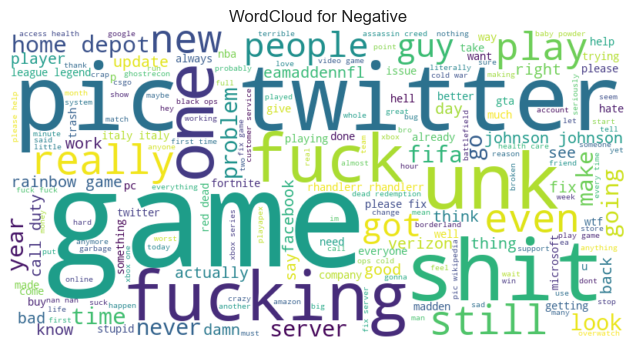

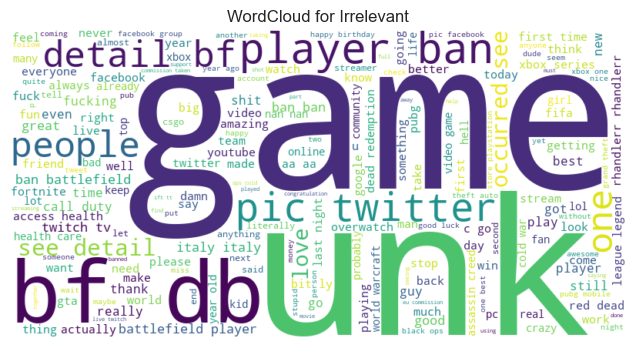

In [4]:
#  Word clouds per sentiment (skip gracefully if not available)

try:
    for s in train['sentiment'].unique():
        text = ' '.join(train.loc[train['sentiment']==s, 'clean'].fillna(''))
        if not text.strip():
            continue
        wc = WordCloud(width=800, height=400, background_color='white').generate(text)
        plt.figure(figsize=(10,4))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis('off')
        plt.title(f'WordCloud for {s}')
        plt.show()
except Exception as e:
    print("WordCloud generation skipped:", str(e))

<Figure size 1000x600 with 0 Axes>

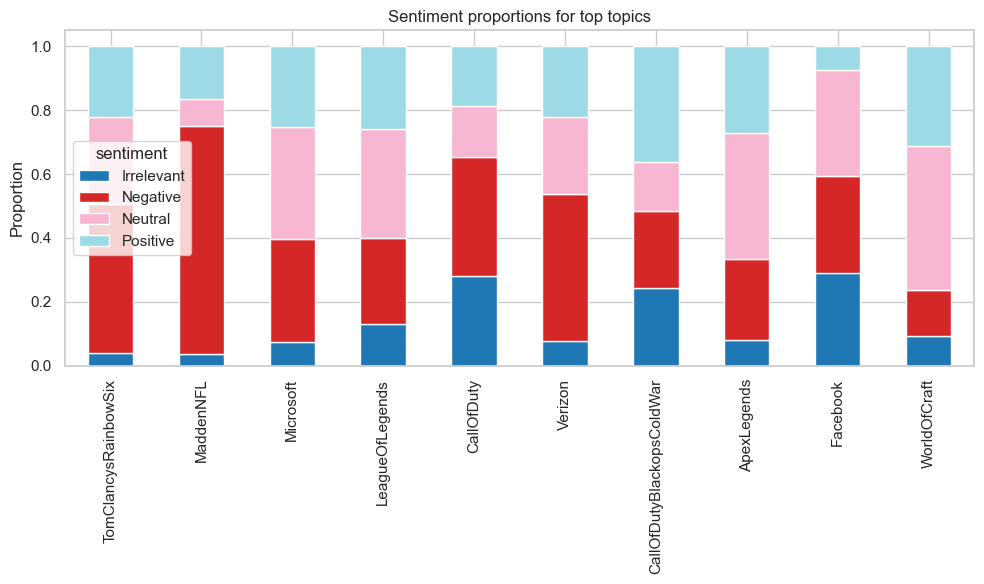

In [5]:
# Per-topic sentiment proportions (attitudes by topic)

topic_sent = train.groupby(['topic','sentiment']).size().unstack(fill_value=0)
topic_sent_prop = topic_sent.div(topic_sent.sum(axis=1), axis=0)

# show top 10 topics by total mentions

top_topic_names = train['topic'].value_counts().nlargest(10).index
plt.figure(figsize=(10,6))
topic_sent_prop.loc[top_topic_names].plot(kind='bar', stacked=True, figsize=(10,6), colormap='tab20')
plt.title('Sentiment proportions for top topics')
plt.ylabel('Proportion')
plt.tight_layout()
plt.show()

In [6]:
# TF-IDF vectorization and baseline model training (with stratified CV)

tfv = TfidfVectorizer(max_features=20000, ngram_range=(1,2))
X_train = tfv.fit_transform(train['clean'])
y_train = train['sentiment']
X_valid = tfv.transform(valid['clean'])
y_valid = valid['sentiment']

model = LogisticRegression(max_iter=1000, class_weight='balanced', random_state=RND)
params = {'C':[0.1,1,5]}
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=RND)
gs = GridSearchCV(model, params, cv=cv, scoring='f1_macro', n_jobs=-1)
gs.fit(X_train, y_train)
best = gs.best_estimator_
print('Best params:', gs.best_params_)
print('CV best score (f1_macro):', gs.best_score_)

Best params: {'C': 5}
CV best score (f1_macro): 0.8196249471648008



Validation classification report:

              precision    recall  f1-score   support

  Irrelevant       0.90      0.95      0.92       172
    Negative       0.97      0.96      0.96       266
     Neutral       0.97      0.95      0.96       285
    Positive       0.93      0.92      0.93       277

    accuracy                           0.94      1000
   macro avg       0.94      0.95      0.94      1000
weighted avg       0.95      0.94      0.95      1000

Macro F1 on validation: 0.9432583033655464


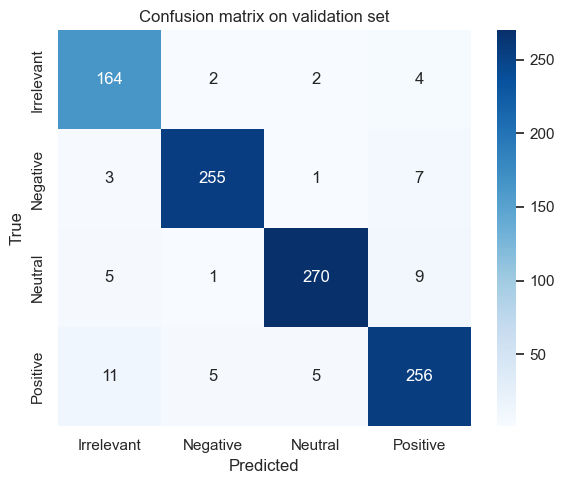

In [7]:
# Evaluation on validation set

pred = best.predict(X_valid)
print('\nValidation classification report:\n')
print(classification_report(y_valid, pred))
print('Macro F1 on validation:', f1_score(y_valid, pred, average='macro'))

cm = confusion_matrix(y_valid, pred, labels=best.classes_)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=best.classes_, yticklabels=best.classes_, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion matrix on validation set')
plt.tight_layout()
plt.show()

In [8]:
# Inspect top terms per sentiment using model coefficients

feature_names = tfv.get_feature_names_out()
classes = best.classes_
coefs = best.coef_
topn = 15
for i, cls in enumerate(classes):
    # get top positive coefficients for class i (one-vs-rest)
    top_indices = coefs[i].argsort()[-topn:][::-1]
    top_terms = [feature_names[j] for j in top_indices]
    print(f"Top terms for {cls}:", ', '.join(top_terms))

Top terms for Irrelevant: overwatch league, modi, poll, montage, wow hearthstone, time xbox, subscribe, zayn, subscriber, fridge, yoga, live amazon, tweeting, polite, sf
Top terms for Negative: fix, matchmaking, glitch, tactical, disrespectful, lobby, boring, plague, ticket, powder, ruining, disrespect, fifa, unfair, screwed
Top terms for Neutral: com, commission, dlvr, chase, earned, forward event, panic, duel, diamond, way excited, confirms, lethal, vision, liberation, nothing well
Top terms for Positive: achievement red, valhalla, excited, facebook com, fun, fave, undertale, awe, refreshing, neon, warlock, whoa, masterpiece, creed, immersive


In [9]:
# Save summary, model and vectorizer

summary = {
    'best_params': gs.best_params_,
    'cv_best_score_f1_macro': float(gs.best_score_),
    'train_counts': train['sentiment'].value_counts().to_dict(),
    'validation_report': classification_report(y_valid, pred, output_dict=True),
    'validation_macro_f1': float(f1_score(y_valid, pred, average='macro'))
}
with open('sentiment_summary.json', 'w', encoding='utf-8') as f:
    json.dump(summary, f, indent=2)

joblib.dump(best, 'lr_best.joblib')
joblib.dump(tfv, 'tfidf_vectorizer.joblib')

print('Saved summary to sentiment_summary.json')
print('Saved model (lr_best.joblib) and vectorizer (tfidf_vectorizer.joblib)')

Saved summary to sentiment_summary.json
Saved model (lr_best.joblib) and vectorizer (tfidf_vectorizer.joblib)


# summary:

Preprocess tweets (cleaning, stopword removal, lemmatization), visualize sentiment/topic patterns, train a TF-IDF + Logistic Regression baseline, evaluate on validation data, interpret top terms, and save results.

# Key steps (brief):

Load training/validation CSVs and clean text.
Preprocess: lowercase, remove URLs/mentions/hashtags/non-letters, remove stopwords, lemmatize.
EDA: class distribution, top topics, per-topic sentiment proportions, and word clouds.
Modeling: TF-IDF (unigrams+bigrams) + Logistic Regression with stratified CV and GridSearch.
Evaluation: classification report, macro F1, confusion matrix, and top predictive terms.
Outputs saved: sentiment_summary.json, lr_best.joblib, tfidf_vectorizer.joblib.

# Next suggested improvement (one line)

Improve text handling (emojis/negation), try transformer models or class rebalancing to raise accuracy.